# <center> NLP - Disaster Tweets </center>

### 1. Load data

In [1]:
# Imports
import numpy as np
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import re
import string


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as py
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [3]:
df_train

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

### 2. EDA

#### 2.1 Checkout a disaster tweet

In [4]:
d_t = df_train[df_train['target'] == 1]['text']
for i in range(1,5):
    print(d_t[i])

Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


#### 2.2 Checkout a non disaster tweet

In [5]:
nd_t = df_train[df_train['target'] != 1]['text']
print(nd_t.head(5))

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object


#### 2.3 Plot null values in train & test dataset

In [6]:
loc_null_values = df_train['location'].isnull().sum()
keyword_null_values =  df_train['keyword'].isnull().sum()
loc_null_values_test = df_test['location'].isnull().sum()
keyword_null_values_test =  df_test['keyword'].isnull().sum()

In [7]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Keyword - Train Dataset'],
    y=[keyword_null_values],
    name='Keyword',
    text=[keyword_null_values],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.add_trace(go.Bar(
    x=['Location - Train Dataset'],
    y=[loc_null_values],
    name='Location',
    text=[loc_null_values],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))
fig.add_trace(go.Bar(
    x=['Keyword - Test Dataset'],
    y=[keyword_null_values],
    showlegend=False,
    text=[keyword_null_values],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.add_trace(go.Bar(
    x=['Location - Test Dataset'],
    y=[loc_null_values_test],
    showlegend=False,
    text=[loc_null_values_test],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Missing values of keyword & location</span>', 
)
fig.show()

#### 2.4 Show the lenght of a tweet

In [8]:
df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split(' ')))

In [9]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_len  
0       1        13  
1       1         7  
2       1        22  
3       1         9  
4       1        17

#### 2.5 Train dataset distribution by Target

In [10]:
balance_counts = df_train.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker = {'color' : 'salmon'}
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker = {'color' : 'cadetblue'}
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

#### 2.6 Target distribution in keywords

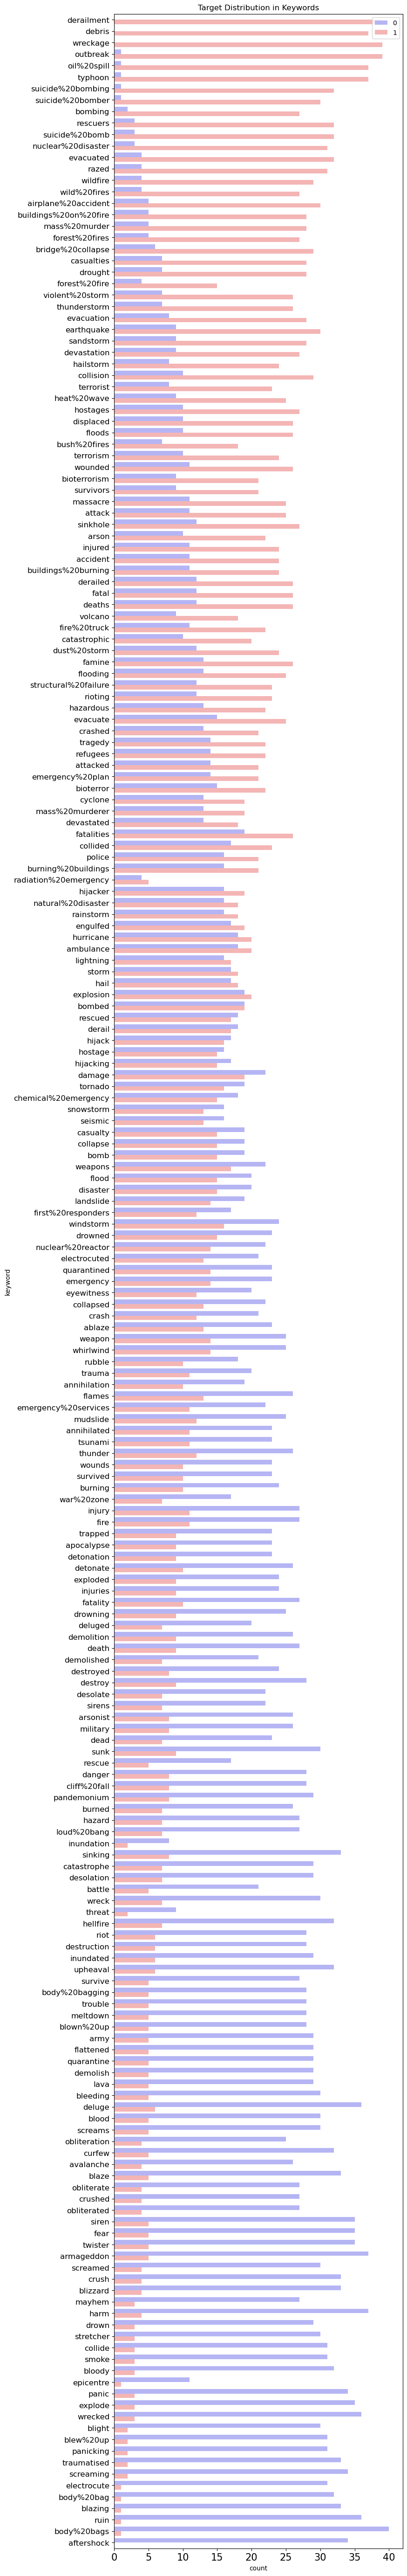

In [12]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], palette='bwr')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

#### 2.7 Word cloud of disaster and non-disaster tweets to see most repeating word

Text(0.5, 1.0, 'Non Disaster tweets')

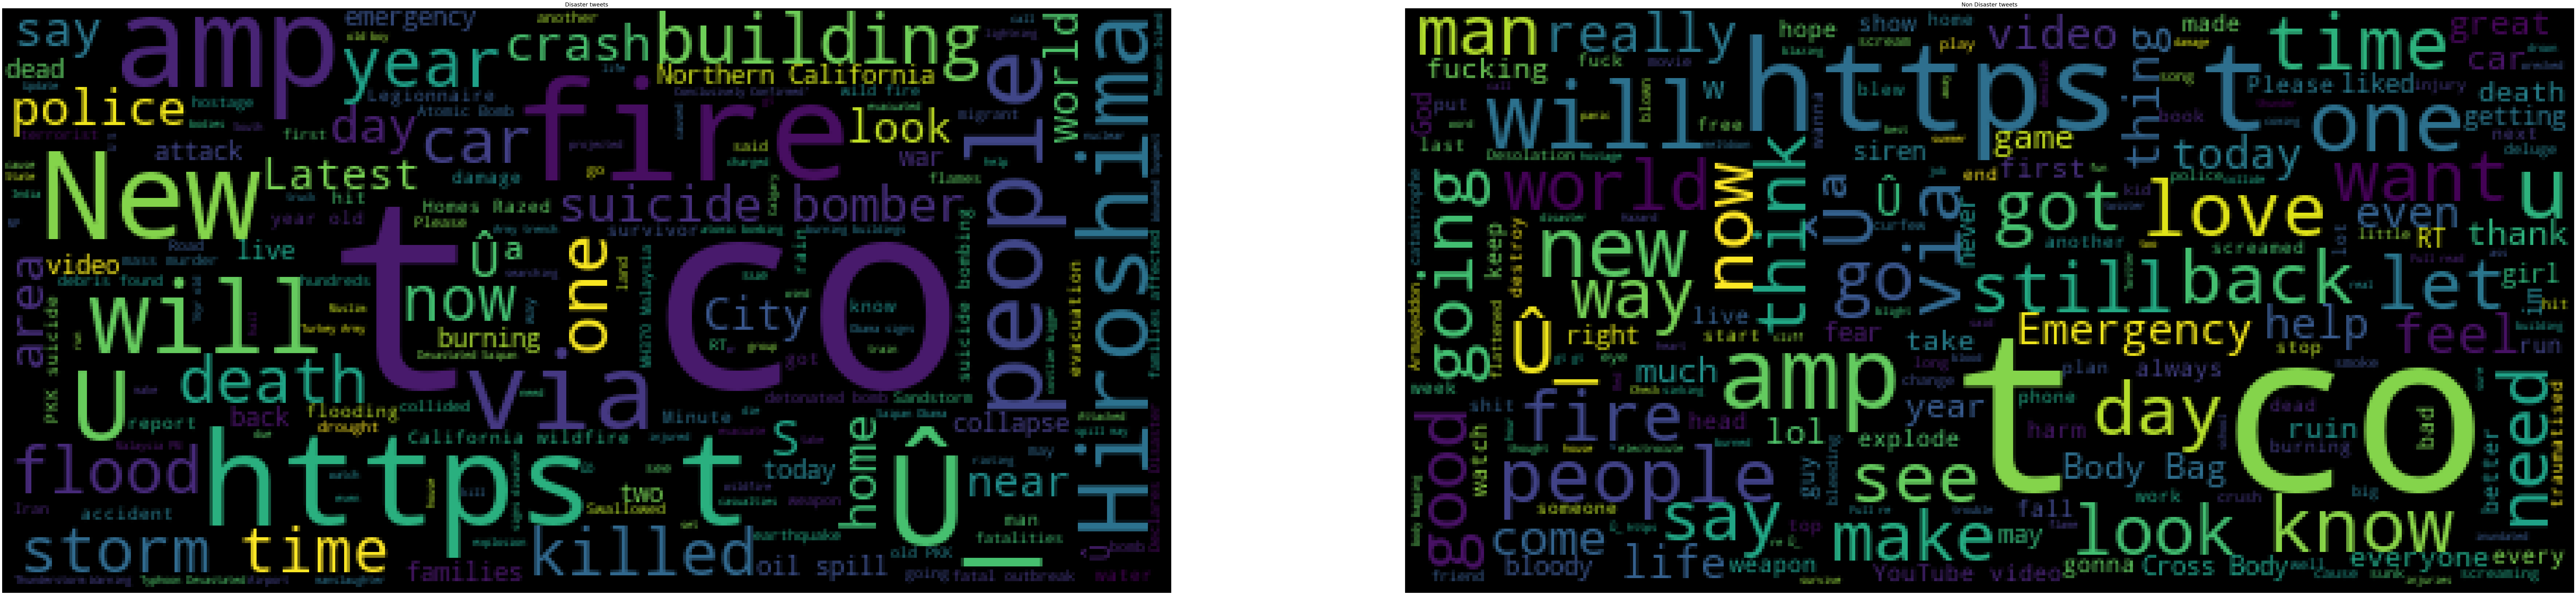

In [13]:
from wordcloud import WordCloud


fig, (ax1, ax2) = plt.subplots(1,2, figsize = [150, 50])

wc1 = WordCloud().generate(''.join(d_t))
ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Disaster tweets', fontsize = 18)

wc2 = WordCloud().generate(''.join(nd_t))
ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Non Disaster tweets', fontsize = 18)

#### 2.8 Top 10 keywords in the dataset

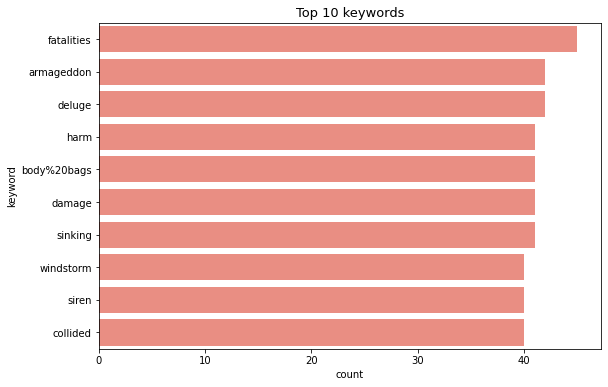

In [14]:
plt.figure(figsize=(9,6))
sns.countplot(y = df_train.keyword, order= df_train.keyword.value_counts().iloc[:10].index, color='salmon')
plt.title('Top 10 keywords', fontsize=13)
plt.show()

#### 2.9 Visualize tweets by location on a map

In [15]:
# !pip install geopy
# !pip install folium

In [16]:
df = df_train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="DC2 - NLP Disaster Tweets")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Chicago, IL
Australia
California
New York, NY
Everywhere
California, USA
San Francisco


In [17]:
map1 = folium.Map(location=[10.0, 10.0], tiles='openstreetmap', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

### 3. Data Preprocessing

#### 3.1 Clean the tweets

Make text lowercase, remove text in square brackets,remove linkemove punctuation and remove words containing numbers.

In [18]:
def clean_text(text):
    # Convert to lower
    text = text.lower()
    # remove html tags
    text = re.sub(r'\[.*?\]',' ', text)
    # remove link
    text = re.sub(r'https?://\S+|www\.\S+',' ', text)
    #remove line breaks
    text = re.sub(r'\n',' ',text)
    #Remove trailing spaces, tabs
    text  = re.sub('\s+',' ',text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove special characters
    text = re.sub('\w*\d\w*','',text)
    return text



# Apply clean function on random train string 
test_str = df_train.loc[417, 'text']
print('Original text: '+test_str+'\n')
print('Text after cleaning: '+clean_text(test_str))
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'].head(5)

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb

Text after cleaning: arson suspect linked to  fires caught in northern california 


0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 3.2 Stopwords

In [19]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'amp']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_train.head(10)

id keyword location                                               text  \
0   1     NaN      NaN       deeds reason earthquake may allah forgive us   
1   4     NaN      NaN              forest fire near la ronge sask canada   
2   5     NaN      NaN  residents asked shelter place notified officer...   
3   6     NaN      NaN   people receive wildfires evacuation orders ca...   
4   7     NaN      NaN  got sent photo ruby alaska smoke wildfires pou...   
5   8     NaN      NaN  rockyfire update  california hwy  closed direc...   
6  10     NaN      NaN  flood disaster heavy rain causes flash floodin...   
7  13     NaN      NaN                            top hill see fire woods   
8  14     NaN      NaN  theres emergency evacuation happening building...   
9  15     NaN      NaN                         afraid tornado coming area   

   target  text_len  
0       1        13  
1       1         7  
2       1        22  
3       1         9  
4       1        17  
5       1        18  
6       1        14  
7       1        15  
8       1        12  
9       1        10

#### 3.3 Tokenization

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer

# tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'\w+')
## Applying tokenization function on train & test sets
df_train['text'] = df_train['text'].map(tokenizer.tokenize)
df_test['text'] = df_test['text'].map(tokenizer.tokenize)
## checkout train dataset tokens
df_train['text'].head(5)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

#### 3.4 Lemmatization

In [21]:
# import nltk
# nltk.download('wordnet')

In [22]:
def lem_words(t):
    l = WordNetLemmatizer()
    return [l.lemmatize(w) for w in t]

df_train['text'] =df_train['text'].apply(lambda x: lem_words(x))
df_test['text'] =df_test['text'].apply(lambda x: lem_words(x))

## checkout train dataset with lemmatized words
df_train['text'].head(5)

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3    [people, receive, wildfire, evacuation, order,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

#### 3.5 Transform tokens into sentences 

In [23]:
def combine_txt(t):
    c  = ' '.join(t)
    return c

df_train['text'] =df_train['text'].apply(lambda x: combine_txt(x))
df_test['text'] =df_test['text'].apply(lambda x: combine_txt(x))

## checkout train dataset with lemmatized words
df_train['text'].head(5)

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

#### 3.6 Wordcloud on the cleaned text

In [24]:
tr = df_train[df_train['target'] == 1]['text']
for i in range(1,5):
    print(tr[i])

forest fire near la ronge sask canada
resident asked shelter place notified officer evacuation shelter place order expected
people receive wildfire evacuation order california
got sent photo ruby alaska smoke wildfire pours school


In [25]:
non = df_train[df_train['target'] != 1]['text']
print(non.head(5))

15          whats man
16         love fruit
17      summer lovely
18           car fast
19    goooooooaaaaaal
Name: text, dtype: object


Text(0.5, 1.0, 'Non Disaster tweets')

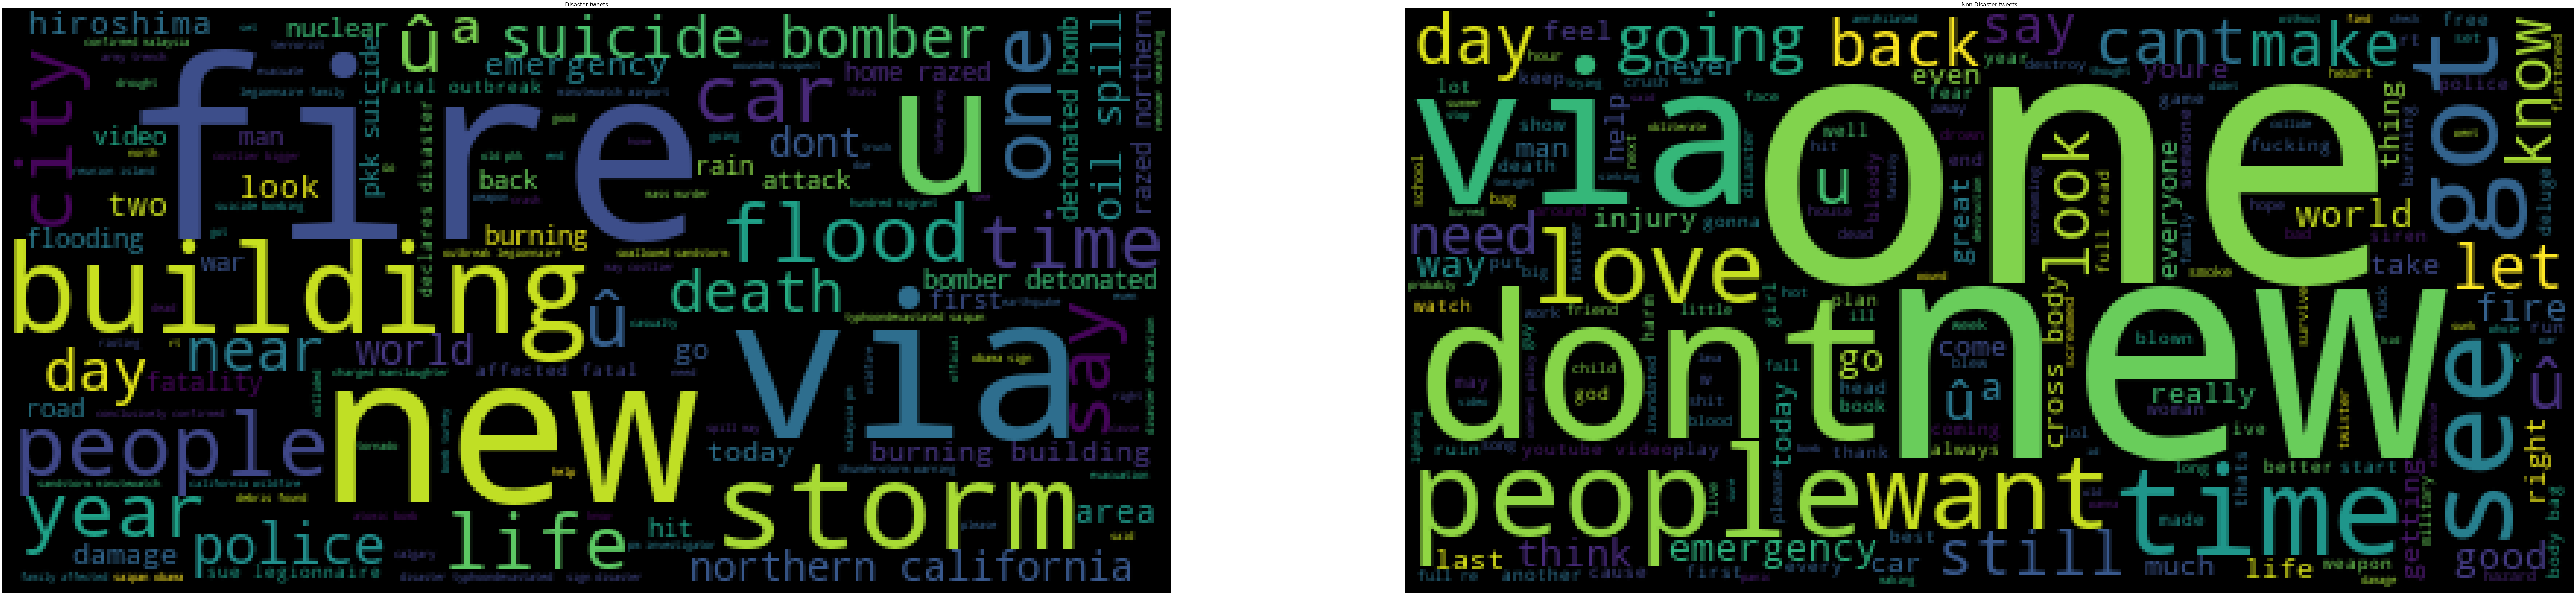

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [150, 50])

wc1 = WordCloud().generate(''.join(tr))
ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Disaster tweets', fontsize = 18)

wc2 = WordCloud().generate(''.join(non))
ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Non Disaster tweets', fontsize = 18)